# Stock Trades by Members of the US House of Representatives

Kelvin Nguyen
<br>Mandy Xu</br>

## Summary of Findings


### Introduction
<br>We will building a binary classifier to predict whether a trade was BUY or SELL. We decided to predict a trade's type because many other features had too many missing values or weren't suitable for a binary classifier. We also felt like we have already done a lot with political affiliation so we wanted to do something different. The features we will be using are amount and party for the baseline model, and district and month for the final model. The metric we will be using to evaluate our model is accuracy since it isn't too detrimental if we obtain a false positive or false negative.</br>
<br>At the time of this prediction, we only have data on the 116th (2019-2020) and 117th (2021-2022) Congress. Thus, our data will only be trained within this time frame and on the members of the 116th and 117th Congress.</br>

### Baseline Model
<br>The features we decided on for the baseline model is amount and party. Amount is ordinal while party is nominal. We ordinally encoded the amount feature by obtaining the lower bound of the amount interval and using sklearn's OrdinalEncoder in ColumnTransformer to do so. For the party feature, we already created a boolean column called is_democratic from Project 3 which we used and left as is since Trues are already encoded to 1 and Falses to 0.</br>
<br>After creating our model using LogisiticRegression, our accuracy score on the training data is about 0.54 to 0.55 and our accuracy score on the testing data is also about 0.54 to 0.55. Based on this, we believe our model is not the best because the accuracy score is only a little over 0.5.</br>

### Final Model
<br>For our final model, we added district and month in addition to the features in the baseline model. We added these features because we believed that there might be a relationship between type and the district the representative came from and the month they traded the stock.</br> 
<br>The model we ended up choosing was Support Vector Classification (SVC) and the hyperparameters we modified were gamma and C. The best hyperparameters were 0.1 for 'svm__gamma' and 1000 for 'svm__C' which gave us a test score of 0.658.</br>
<br>We also tested two other models in addition to SVC using GridSearchCV with k=5 cross-validation: LogisiticRegression and RandomForestClassifier. For LogisiticRegression, the hyperparameters we modified were penalty, C, and solver. We obtained a test score of about 0.563. For RandomForestClassifier, we modified max_depth, n_estimators, and min_samples_split. We obtained a test score of about 0.580.</br>

### Fairness Analysis
<br>In our fairness analysis, we tried to answer the question "Does our model perform worse for Democratic House members than it does for non-Democratic House members? Thus, our null hypothesis is "Our model is fair. Its accuracy for Democratic House members and non-Democratic House members are roughly the same, and any differences are due to random chance" and our alternative hypothesis is "Our model is unfair. Its accuracy for Democratic House members is lower than its accuracy for non-Democratic House members". Our test statistic is the difference in accuracy between political affiliations. Based on our permutation test, we obtained a p-value of 0.002 which is less than our chosen significance level of 0.05. Therefore, since we reject the null hypothesis, our conclusion is that our model is unfair.</br>

## Code

### Getting and Cleaning Dataset (from Project 3)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in datasets
# stocks
stocks_fp = os.path.join('data', 'all_transactions.csv')
stocks = pd.read_csv(stocks_fp)

# past House members political affiliation - 116th and 117 Congress
reps_party_116_fp = os.path.join('data', 'house_members_116.csv')
reps_party116 = pd.read_csv(reps_party_116_fp)

reps_party_117_fp = os.path.join('data', 'house_members_117.csv')
reps_party117 = pd.read_csv(reps_party_117_fp)

In [3]:
# Clean stocks
# Clean null vals
stocks_cleaned = stocks.replace({'--': np.NaN})

# Clean representative column (for merging)
reps_split = stocks_cleaned['representative'].str.lower().str.split()
stocks_cleaned['representative_cleaned'] = reps_split.str[1] + ' ' + reps_split.str[-1]

# Clean amount column
replace_dict = {
    '$1,001 -': '$0 - $1000',
    '$1,000,001 - $5,000,000': '$1,000,001 +',
    '$1,000,000 - $5,000,000': '$1,000,001 +',
    '$50,000,000 +': '$1,000,001 +',
    '$15,000 - $50,000': '$15,001 - $50,000',
    '$1,000,000 +': '$1,000,001 +',
    '$1,000 - $15,000': '$1,001 - $15,000',
    '$5,000,001 - $25,000,000': '$1,000,001 +'
    
}
stocks_cleaned['amount_cleaned'] = stocks_cleaned['amount'].replace(replace_dict)

# Clean reps_party116
# Clean name column (for merging)
reps_party_116_cleaned = reps_party116[['name', 'current_party']]
reps_party_116_cleaned.loc[:, 'name'] = reps_party_116_cleaned['name'].str.replace('-', ' ').str.lower()
reps_party_116_cleaned = reps_party_116_cleaned.set_index('name')

# Clean reps_party117
# Clean column names and Member column (for merging)
reps_party_117_cleaned = reps_party117[['Member', 'Party.1']]
reps_117_split = reps_party_117_cleaned['Member'].str.lower().str.split()
reps_party_117_cleaned.loc[:, 'Member'] = reps_117_split.str[0] + ' ' + reps_117_split.str[-1]
reps_party_117_cleaned = reps_party_117_cleaned.rename(columns={'Party.1': 'Party'}).set_index('Member')

In [4]:
# Merge reps_party_116_cleaned and reps_party_117_cleaned
merge_parties = reps_party_116_cleaned.merge(reps_party_117_cleaned, 
                                             how='outer', 
                                             left_index=True,
                                             right_index=True).reset_index()
merge_parties = (
    merge_parties.bfill(axis=1)[['index', 'current_party']].set_index('index')
)

# Merge stocks and merge_parties
stocks_cleaned_test = stocks_cleaned.set_index('representative_cleaned')
merged = stocks_cleaned_test.merge(merge_parties, how='left', left_index=True, right_index=True).reset_index()

In [5]:
# Fill in missing political parties
keys = merged[merged['current_party'].isna()]['index'].unique()
parties = ['r','d','r','r','r','r','r','d','r','r','r','r','r','r','r','r','r','r','r','d','d','r','d']
fill_vals = dict(zip(keys, parties))
merged = merged.set_index('index')
merged['current_party'] = merged['current_party'].fillna(value = fill_vals).replace({'r': 'Republican', 'd': 'Democratic'})
merged = merged.reset_index()

# Rename 'index' to 'representative_cleaned'
merged = merged.rename(columns={'index': 'representative_cleaned'})

# Add is_democratic column
merged['is_democratic'] = merged['current_party'].apply(lambda x: True if x == 'Democratic' else False)
merged.head()

,representative_cleaned,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,amount_cleaned,current_party,is_democratic
0,abigail spanberger,2021,06/03/2021,2021-06-01,self,LHX,L3Harris Special Stock Grant,purchase,"$1,001 - $15,000",Hon. Abigail Spanberger,VA07,https://urldefense.com/v3/__https://disclosures-clerk.house.gov/public_dis__;!!Mih3wA!C4zLWSCBWRaQgfdatE0RTdk_z0CWoRqZf1BZssCEJSXXv5YnFqGotT4gVBEynILw7p3Zp5jTZwmydQTkUA$ ...,False,"$1,001 - $15,000",Democratic,True
1,abigail spanberger,2020,03/20/2020,2020-02-28,self,NaN,L3Harris Special Stock Grant,purchase,"$1,001 - $15,000",Hon. Abigail Spanberger,VA07,https://urldefense.com/v3/__https://disclosures-clerk.house.gov/public_dis__;!!Mih3wA!C4zLWSCBWRaQgfdatE0RTdk_z0CWoRqZf1BZssCEJSXXv5YnFqGotT4gVBEynILw7p3Zp5jTZwmydQTkUA$ ...,False,"$1,001 - $15,000",Democratic,True
2,adam kinzinger,2020,07/21/2020,2020-06-09,NaN,AAL,"American Airlines Group, Inc.",purchase,"$1,001 - $15,000",Hon. Adam Kinzinger,IL16,https://urldefense.com/v3/__https://disclosures-clerk.house.gov/public_dis__;!!Mih3wA!C4zLWSCBWRaQgfdatE0RTdk_z0CWoRqZf1BZssCEJSXXv5YnFqGotT4gVBEynILw7p3Zp5jTZwmydQTkUA$ ...,False,"$1,001 - $15,000",Republican,False
3,adam kinzinger,2020,07/21/2020,2020-06-11,NaN,AAL,"American Airlines Group, Inc.",purchase,"$1,001 - $15,000",Hon. Adam Kinzinger,IL16,https://urldefense.com/v3/__https://disclosures-clerk.house.gov/public_dis__;!!Mih3wA!C4zLWSCBWRaQgfdatE0RTdk_z0CWoRqZf1BZssCEJSXXv5YnFqGotT4gVBEynILw7p3Zp5jTZwmydQTkUA$ ...,False,"$1,001 - $15,000",Republican,False
4,adam kinzinger,2020,07/21/2020,2020-06-25,NaN,AAL,"American Airlines Group, Inc.",purchase,"$1,001 - $15,000",Hon. Adam Kinzinger,IL16,https://urldefense.com/v3/__https://disclosures-clerk.house.gov/public_dis__;!!Mih3wA!C4zLWSCBWRaQgfdatE0RTdk_z0CWoRqZf1BZssCEJSXXv5YnFqGotT4gVBEynILw7p3Zp5jTZwmydQTkUA$ ...,False,"$1,001 - $15,000",Republican,False


### Baseline Model

#### Cleaning and Encoding Columns

In [6]:
stocks_df = merged[['amount_cleaned', 'is_democratic', 'district', 'transaction_date', 'type']]
stocks_df.head()

,amount_cleaned,is_democratic,district,transaction_date,type
0,"$1,001 - $15,000",True,VA07,2021-06-01,purchase
1,"$1,001 - $15,000",True,VA07,2020-02-28,purchase
2,"$1,001 - $15,000",False,IL16,2020-06-09,purchase
3,"$1,001 - $15,000",False,IL16,2020-06-11,purchase
4,"$1,001 - $15,000",False,IL16,2020-06-25,purchase


In [7]:
# amount - create lower bound
stocks_df['amount_lower'] = (stocks_df['amount_cleaned'].str.split(' - ')
                                                        .str[0].str.replace('$', '')
                                                        .str.replace(',', '')
                                                        .str.replace('+', '')
                                                        .str.replace(' ', '')
                                                        .astype(float))

# type - remove
stocks_df = stocks_df[stocks_df['type'] != 'exchange']
stocks_df['is_purchase'] = stocks_df['type'].str.contains('purchase')
stocks_df['state'] = stocks_df['district'].str[:2]

# transaction_date - get month
stocks_df['transaction_month'] = stocks_df['transaction_date'].str.split('-').str[1].astype(int)
stocks_df.head()

,amount_cleaned,is_democratic,district,transaction_date,type,amount_lower,is_purchase,state,transaction_month
0,"$1,001 - $15,000",True,VA07,2021-06-01,purchase,1001.0,True,VA,6
1,"$1,001 - $15,000",True,VA07,2020-02-28,purchase,1001.0,True,VA,2
2,"$1,001 - $15,000",False,IL16,2020-06-09,purchase,1001.0,True,IL,6
3,"$1,001 - $15,000",False,IL16,2020-06-11,purchase,1001.0,True,IL,6
4,"$1,001 - $15,000",False,IL16,2020-06-25,purchase,1001.0,True,IL,6


#### Creating Baseline Model

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [9]:
preproc = ColumnTransformer(
    transformers=[
        ('ord-encoder', OrdinalEncoder(), ['amount_lower'])
    ],
    remainder='passthrough'
)

pl = Pipeline([
    ('preprocessor', preproc),
    ('log-reg', LogisticRegression())
])

X = stocks_df[['is_democratic', 'amount_lower']]
y = stocks_df['is_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
pl.fit(X_train, y_train)
pl.score(X_train, y_train)

0.5475241889584519

In [11]:
pl.score(X_test, y_test)

0.5445234708392603

### Final Model

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [26]:
preproc = ColumnTransformer(
    transformers=[
        ('ord-encoder', OrdinalEncoder(), ['amount_lower']),
        ('one-hot', OneHotEncoder(), ['state', 'transaction_month']),
    ],
    remainder='passthrough'
)

X = stocks_df[['is_democratic', 'amount_lower', 'state', 'transaction_month']]
y = stocks_df['is_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
pl_svc = Pipeline([
    ('preprocessor', preproc),
    ('svm', SVC())
])

hyperparams_svc = {
    'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svm__C': [0.1, 1, 10, 100, 1000]
}

best_mdl = GridSearchCV(pl_svc, param_grid=hyperparams_svc, scoring='accuracy', cv=5)
best_mdl.fit(X_train, y_train)
print(best_mdl.best_params_)
best_mdl.score(X_train, y_train)

{'svm__C': 0.1, 'svm__gamma': 1}


0.6739707835325365

In [15]:
best_mdl.score(X_test, y_test)

0.658321479374111

In [16]:
# LogisiticRegression
pl_lr = Pipeline([
    ('preprocessor', preproc),
    ('lr', LogisticRegression())
])

hyperparams_lr = {
    'lr__penalty': ['l2'],
    'lr__C': np.logspace(-3,3,7),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

mdl_lr = GridSearchCV(pl_lr, param_grid=hyperparams_lr, scoring='accuracy', cv=5)
mdl_lr.fit(X_train, y_train)
print(mdl_lr.best_params_)
mdl_lr.score(X_train, y_train)

{'lr__C': 0.001, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}


0.5549231644849175

In [17]:
mdl_lr.score(X_test, y_test)

0.5627311522048364

In [19]:
# RandomForestClassifier
pl_rf = Pipeline([
    ('preprocessor', preproc),
    ('rf', RandomForestClassifier())
])

hyperparams_rf = {
    'rf__max_depth': np.arange(2, 11, 1),
    'rf__n_estimators': np.arange(20, 151, 10),
    'rf__min_samples_split': np.arange(2, 11, 1)
}

mdl_rf = GridSearchCV(pl_rf, param_grid=hyperparams_rf, scoring='accuracy', cv=5)
mdl_rf.fit(X_train, y_train)
print(mdl_rf.best_params_)
mdl_rf.score(X_train, y_train)

{'rf__max_depth': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}


0.5714285714285714

In [20]:
mdl_rf.score(X_test, y_test)

0.5800853485064011

### Fairness Analysis

In [24]:
from sklearn import metrics

In [27]:
results = X_test
results['prediction'] = best_mdl.predict(X_test)
results['party'] = y_test
results.head()

,is_democratic,amount_lower,state,transaction_month,prediction,party
3544,True,15001.0,FL,6,False,False
12219,True,15001.0,CA,2,True,True
8998,True,1001.0,OR,2,True,True
10698,False,100001.0,TX,11,True,False
699,False,1000001.0,IA,3,True,False


In [40]:
obs = (
    results.groupby('is_democratic')
    .apply(lambda x: metrics.accuracy_score(x['party'], x['prediction']))
    .diff().iloc[-1]
)
obs

-0.08544486315305277

In [41]:
diff_scores = []
for _ in range(1000):
    s = (
        results[['is_democratic', 'prediction', 'party']]
        .assign(is_democratic=results.is_democratic.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_democratic')
        .apply(lambda x: metrics.accuracy_score(x['party'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    diff_scores.append(s)

In [42]:
# p-value
(diff_scores <= obs).mean()

0.002

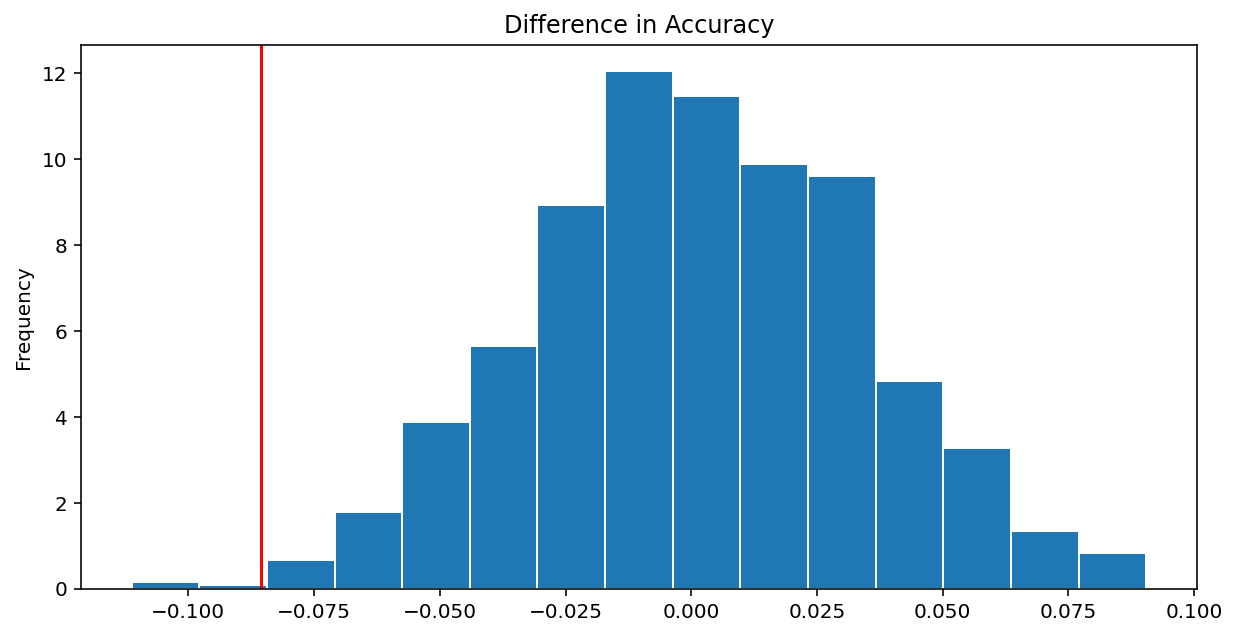

In [43]:
plt.figure(figsize=(10, 5))
pd.Series(diff_scores).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy')
plt.axvline(x=obs, color='red', label='observed difference in accuracy')